# Modeling

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
import warnings; warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.10f}'.format
plt.rcParams['figure.figsize'] = (8, 4)

In [2]:
#LOAD LOANSTATS
directory = '../../data/'
ls = pd.read_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')
ls.sort_index(axis=1, inplace=True)

This section presents the modeling we have undertaken to determine which loan features are most predictive of loan outcomes. A discussion of the results and implications follows in the [Investment Strategy](https://cs109group67.github.io/lendingclub/Strategy.html) section.

## 1. Preprocessing

### 1A. Train-Test Split

Before we begin modeling, we set aside a test set that we will use later to evaluate the predictive quality of our investment strategy. We do this in a stratified fashion ensuring that the outcome classes (fully paid loans and not fully paid loans) are equally represented in the train and test sets. For the splitting algorithm, we use `sklearn`'s `train_test_split` function. This function creates random train and test subsets of the dataset. The flag `stratify` ensures that both classes are equally represented in each set. 

In [3]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.2, stratify=ls['OUT_Class'], random_state=1)

### 1B. Standard Scaling

The models used in the next sections assume that the features are on similar scales. To achieve this, we transform the numeric variables to a standard scale with mean 0 and standard deviation 1 using sklearn's `StandardScaler` function.

In [4]:
#SEPARATE FEATURE AND TARGET SETS
var_list = ls.columns
outcome_var_list = sorted(out_var for out_var in var_list if "OUT_" in out_var)
dummy_var_list = sorted(dummy for dummy in var_list if "D_" in dummy)
numeric_var_list = sorted(set(var_list) - set(outcome_var_list) - set(dummy_var_list))

#train feature
X_train = ls_train[sorted(set(var_list)-set(outcome_var_list))]

#test feature
X_test = ls_test[sorted(set(var_list)-set(outcome_var_list))]

#train targets
y_train = ls_train[sorted(outcome_var_list)]
OUT_Class_train = y_train.iloc[:,0]
OUT_Principle_Repaid_Percentage_train = y_train.iloc[:,1]
OUT_Monthly_Rate_Of_Return_train = y_train.iloc[:,2]

#test targets
y_test = ls_test[sorted(outcome_var_list)]
OUT_Class_test = y_test.iloc[:,0]
OUT_Principle_Repaid_Percentage_test = y_test.iloc[:,1]
OUT_Monthly_Rate_Of_Return_test = y_test.iloc[:,2]

In [5]:
#STANDARD SCALING
scaler = StandardScaler()

#train data -> fit_transform
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

#test data -> transform
X_test_scaled = pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

### 1C. Model Evaluation Functions

In [6]:
def model_scoring(model, feature, target, modeltype='C', cv=5):
    """Displays model evaluation for regression and classification modeling"""
    scores = ['accuracy', 'precision', 'recall']
    if modeltype=='R': # regression
        scores = ['neg_mean_squared_error', 'r2']
    for score in scores:
        cv_score = cross_val_score(model, feature, target, scoring=score, cv=cv).mean()
        print('\tCross-validation {}: {:.4}'.format(score, cv_score))

In [7]:
class_names = ['Fully Repaid', 'Not Fully Repaid']
def display_confusion_matrix(target, target_predicted):
    """Displays confusion matrix for classification models"""
    fig, ax = plt.subplots(figsize=(8,4))
    matrix = pd.DataFrame(confusion_matrix(target, target_predicted),
                      index=class_names,
                      columns=class_names)
    sns.heatmap(matrix, annot=True, fmt='g', cbar=None, cmap='Blues')
    plt.title('Confusion Matrix'), plt.ylabel('True Class'), plt.xlabel('Predicted Class')
    ax.set_xticklabels(['Charged Off', 'Fully Repaid'], va='center')
    ax.set_yticklabels(['Charged Off', 'Fully Repaid'], va='center')
    plt.tight_layout()
    plt.show()

In [8]:
def display_ROC_curve(target, target_probabilities):
    """Displays the ROC curve for classification models"""
    fig, ax = plt.subplots(figsize=(10,4))
    true_pr, false_pr, threshold = roc_curve(target, target_probabilities)

    ax.plot(false_pr, true_pr, label='ROC')
    ax.plot([0,1], ls='--',label='random')
    ax.plot([0,0],[1,0], c='.7', ), plt.plot([1,1], c='.7', label='perfect')
    ax.set_title('Reciever Operating Characterisic')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.legend()
    plt.show()

In [9]:
def plot_coefficients(feature_train, figsize=(8,20), **models):
    """Plots the coefficients assigned by the model to each feature"""
    # create DataFrame with coefficient names and values 
    names = feature_train.columns.tolist()
    coefs = pd.DataFrame(names, columns=['coefs'])
    for k,m in models.items():
        coefs[k] = m.coef_.flatten()
    coefs = coefs.sort_values(by='coefs', ascending=False)

    # # plot coefficients for each feature
    coefs.sort_index(inplace=True, ascending=False)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    for k,m in models.items():
        ax.scatter(coefs[k], coefs['coefs'], alpha=0.9, label=k, s=80)
    ax.legend(fontsize=10)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Features')
    ax.set_title('The Coefficients Assigned for Each Feature')
    ax.axvline(0, color='black')
    plt.show()

## 2. `OUT_Class`

### 2A. Baseline Classification
It is insightful to create some very simple models that we can use as a baseline to compare against our actual model. A basic measure of a classifier's performance is how much it improves on random guessing. Using sklearn's `dummyclassifer` with flag `strategy='uniform'` generates predictions uniformly at random between the different classes.

In [10]:
#DUMMY CLASSIFIER OF 'OUT_Class' 
dummy_classifier = DummyClassifier(strategy='uniform', random_state=1)
dummy_classifier.fit(X_train_scaled, OUT_Class_train)
print(dummy_classifier)

DummyClassifier(constant=None, random_state=1, strategy='uniform')


In [11]:
print('Train scores:')
model_scoring(dummy_classifier, X_train_scaled, OUT_Class_train)
print('Test scores:')
model_scoring(dummy_classifier, X_test_scaled, OUT_Class_test)

Train scores:
	Cross-validation accuracy: 0.5016
	Cross-validation precision: 0.864
	Cross-validation recall: 0.5025
Test scores:
	Cross-validation accuracy: 0.5011
	Cross-validation precision: 0.8644
	Cross-validation recall: 0.5016


### 2B. Logistic Regression Classification

This model is a logistic regression on the outcome variable `OUT_class` which is the binary classification for loans are either fully repaid (1) or charged off (0). The flag `class_weight='balanced'` ensures that both classes are equally represented in each set. We use cross validation to select the best hyperparameter for the inverse regularization strength.

In [12]:
#LOGISTIC REGRESSION
log_reg = LogisticRegressionCV(Cs=8, solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=0, fit_intercept=False)
log_reg.fit(X_train_scaled, OUT_Class_train)
print(log_reg)

LogisticRegressionCV(Cs=8, class_weight='balanced', cv='warn', dual=False,
           fit_intercept=False, intercept_scaling=1.0, max_iter=10000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)


In [13]:
print('Train scores:')
model_scoring(log_reg, X_train_scaled, OUT_Class_train)
print('Test scores:')
model_scoring(log_reg, X_test_scaled, OUT_Class_test)
print()

Train scores:
	Cross-validation accuracy: 0.5648
	Cross-validation precision: 0.9258
	Cross-validation recall: 0.5398
Test scores:
	Cross-validation accuracy: 0.5654
	Cross-validation precision: 0.9255
	Cross-validation recall: 0.5407


In [14]:
print(classification_report(OUT_Class_test, log_reg.predict(X_test_scaled), target_names=class_names))

                  precision    recall  f1-score   support

    Fully Repaid       0.20      0.72      0.31      9337
Not Fully Repaid       0.92      0.54      0.68     59566

       micro avg       0.57      0.57      0.57     68903
       macro avg       0.56      0.63      0.50     68903
    weighted avg       0.83      0.57      0.63     68903



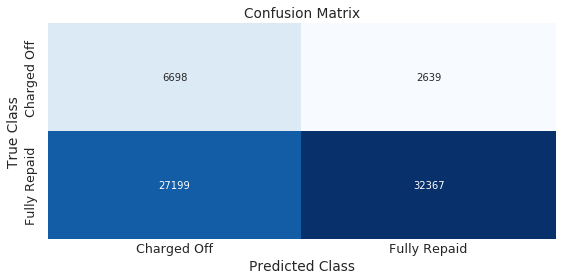

In [15]:
#CONFUSION MATRIX
display_confusion_matrix(OUT_Class_test, log_reg.predict(X_test_scaled))

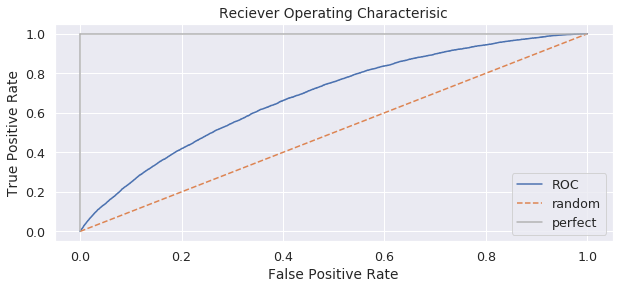

In [16]:
#ROC CURVE
display_ROC_curve(OUT_Class_test, log_reg.predict_proba(X_test_scaled)[:,0])

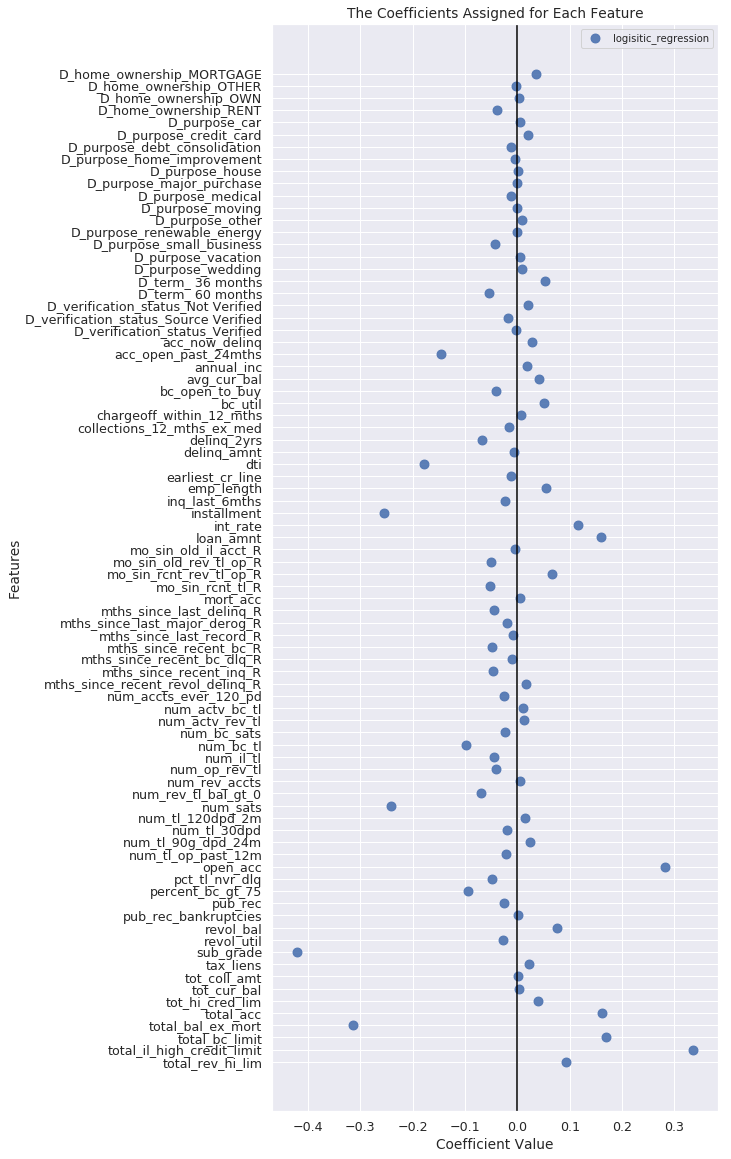

In [17]:
plot_coefficients(X_train_scaled, logisitic_regression=log_reg)

## 3 `OUT_Principle_Repaid_Percentage`

### 3A. Baseline Regression
A basic measure of a regressor's performance is how much better it is than a very simple model that makes constant predictions. Using sklearn's `DummyRegressor` with the flag `strategy='mean'` we get baseline predictions of the mean value in the training set.

In [19]:
#DUMMY REGRESSOR OF 'OUT_Principle_Repaid_Percentage' 
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
print(dummy_reg)

DummyRegressor(constant=None, quantile=None, strategy='mean')


In [20]:
print('Train scores:')
model_scoring(dummy_reg, X_train_scaled, OUT_Principle_Repaid_Percentage_train, modeltype='R')
print('Test scores:')
model_scoring(dummy_reg, X_test_scaled, OUT_Principle_Repaid_Percentage_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -0.00223
	Cross-validation r2: -1.209e-05
Test scores:
	Cross-validation neg_mean_squared_error: -0.002236
	Cross-validation r2: -1.893e-05


### 3B. Linear Regression
Linear regression assumes that the relationship between the features and the outcome vector is approximately linear. We use the flag `fit_intercept=False` because by applying one-hot encoding for the dummy variables without discarding one dummy variable we have already inplicitly added an intercept term.

In [21]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
print(linear_reg)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)


In [22]:
print('Train scores:')
model_scoring(linear_reg, X_train_scaled, OUT_Principle_Repaid_Percentage_train, modeltype='R')
print('Test scores:')
model_scoring(linear_reg, X_test_scaled, OUT_Principle_Repaid_Percentage_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -0.002214
	Cross-validation r2: 0.00711
Test scores:
	Cross-validation neg_mean_squared_error: -0.002224
	Cross-validation r2: 0.005207


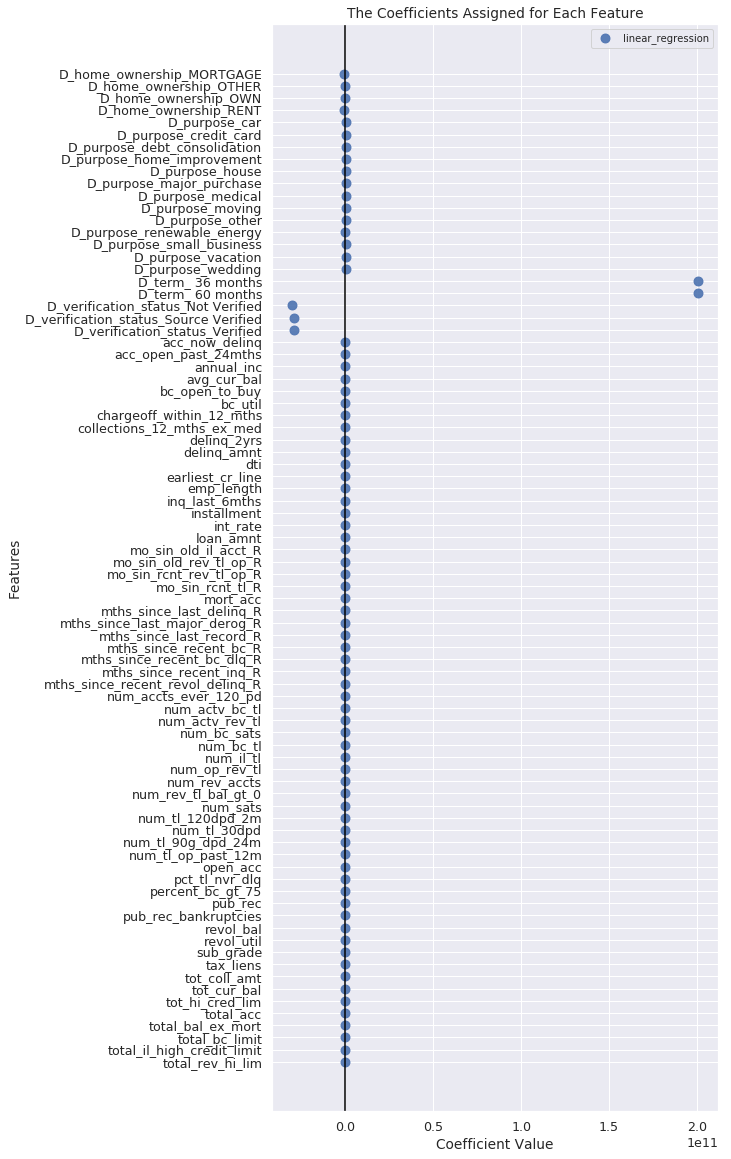

In [23]:
plot_coefficients(X_train_scaled, linear_regression=linear_reg)

### 3C. Ridge Regression
It will be useful to reduce the variance of the coefficients. By applying a shrinkage penalty (aka regularization) we can attempt to minimize RSS and some penalty for the magnitude of the coefficient values. With Ridge the shrinkage penalty is a tuning hyperparameter multiplied by the squared sum of all the coefficients. The hyperparameter alpha lets us control how much we penalize the coefficients

In [24]:
ridge_reg = RidgeCV(fit_intercept=False)
ridge_reg.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
ridge_reg

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=False,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [25]:
print("Train set scores:")
model_scoring(ridge_reg, X_train_scaled, OUT_Principle_Repaid_Percentage_train, modeltype='R')
print("Test set scores:")
model_scoring(ridge_reg, X_test_scaled, OUT_Principle_Repaid_Percentage_test, modeltype='R')

Train set scores:
	Cross-validation neg_mean_squared_error: -0.002213
	Cross-validation r2: 0.007235
Test set scores:
	Cross-validation neg_mean_squared_error: -0.002223
	Cross-validation r2: 0.005698


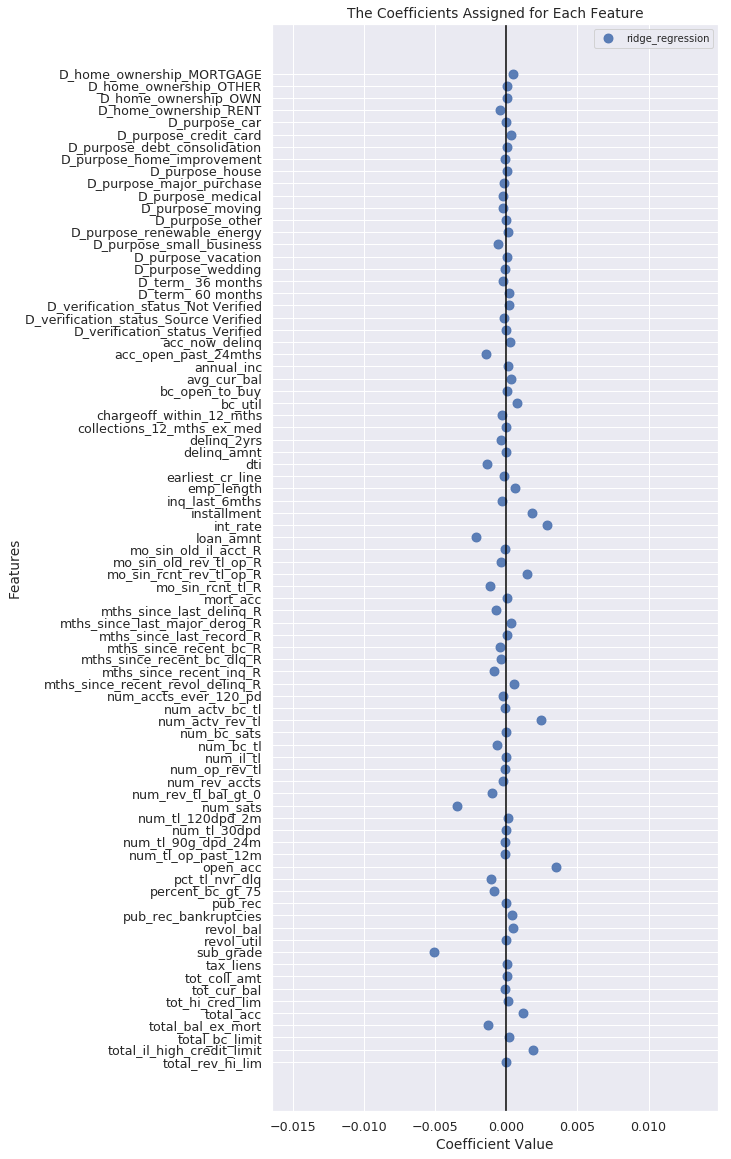

In [26]:
plot_coefficients(X_train_scaled, ridge_regression=ridge_reg)

### 3D. Lasso Regression
Lasso regression often produces more interpretable models than Ridge regression. In Lasso the shrinkage penalty is a tuning hyperparameter multiplied by the sum of the absolute value of all coefficients. This method is more effective at shrinking the coefficients to zero, effectively reducing the number of features in the model.

In [27]:
lasso_reg = LassoCV(fit_intercept=False)
lasso_reg.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
print(lasso_reg)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


In [28]:
print("Train set scores:")
model_scoring(lasso_reg, X_train_scaled, OUT_Principle_Repaid_Percentage_train, modeltype='R')
print("Test set scores:")
model_scoring(lasso_reg, X_test_scaled, OUT_Principle_Repaid_Percentage_test, modeltype='R')

Train set scores:
	Cross-validation neg_mean_squared_error: -0.002212
	Cross-validation r2: 0.00806
Test set scores:
	Cross-validation neg_mean_squared_error: -0.002223
	Cross-validation r2: 0.005764


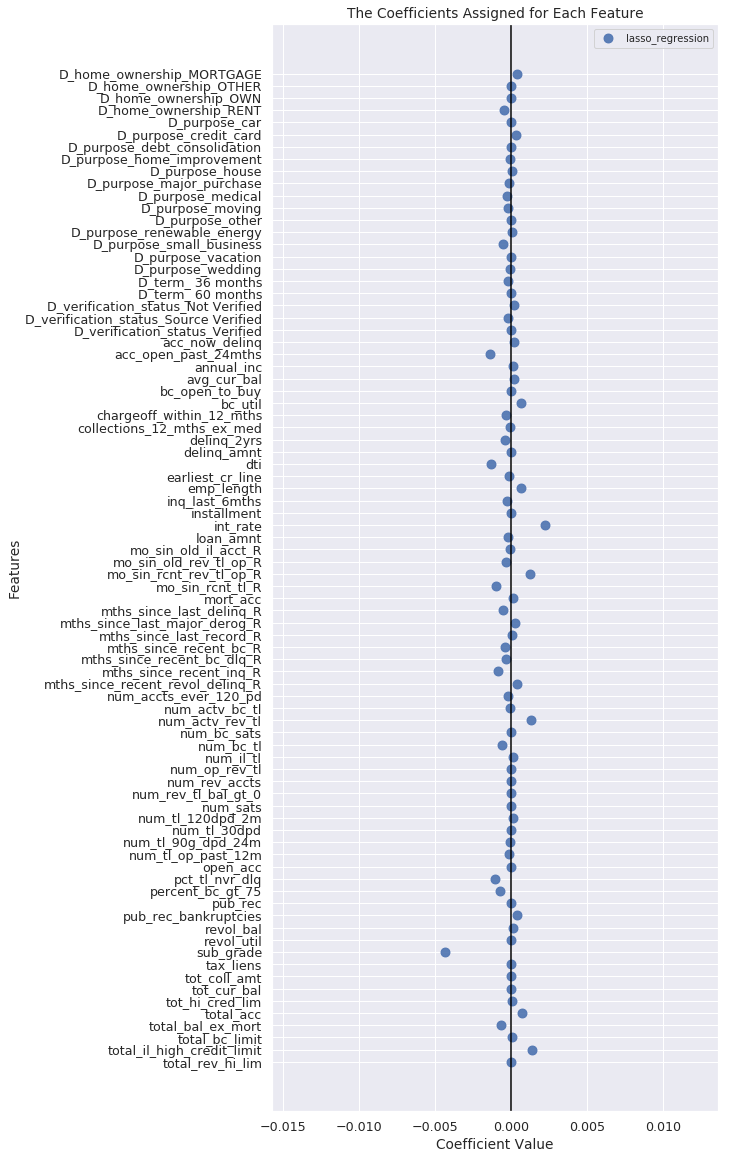

In [29]:
plot_coefficients(X_train_scaled, lasso_regression=lasso_reg)

### 3E. Polynomial Lasso Regression
Polynomial regression is an extension of linear regression to model non-linear relationships. 

In [33]:
#GET POLYNOMIALS
poly_2 = pd.DataFrame(np.hstack((X_train.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_train.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_train_2 = pd.concat([ls_train[dummy_var_list], poly_2], axis=1).sort_index(axis=1)
poly_2 = pd.DataFrame(np.hstack((X_test.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_test.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_test_2 = pd.concat([ls_test[dummy_var_list], poly_2], axis=1).sort_index(axis=1)

In [34]:
#STANDARD SCALING
scaler = StandardScaler()
X_train_scaled_2 = pd.DataFrame(scaler.fit_transform(X_train_2),index=X_train_2.index, columns=X_train_2.columns)
X_test_scaled_2 = pd.DataFrame(scaler.transform(X_test_2),index=X_test_2.index, columns=X_test_2.columns)

In [35]:
lasso_reg2 = LassoCV(fit_intercept=False)
lasso_reg2.fit(X_train_scaled_2, OUT_Principle_Repaid_Percentage_train)
print(lasso_reg2)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


In [36]:
print("Train scores:")
model_scoring(lasso_reg2, X_train_scaled_2, OUT_Principle_Repaid_Percentage_train, modeltype='R')
print("Test scores:")
model_scoring(lasso_reg2, X_test_scaled_2, OUT_Principle_Repaid_Percentage_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -0.00221
	Cross-validation r2: 0.008666
Test scores:
	Cross-validation neg_mean_squared_error: -0.002224
	Cross-validation r2: 0.005607


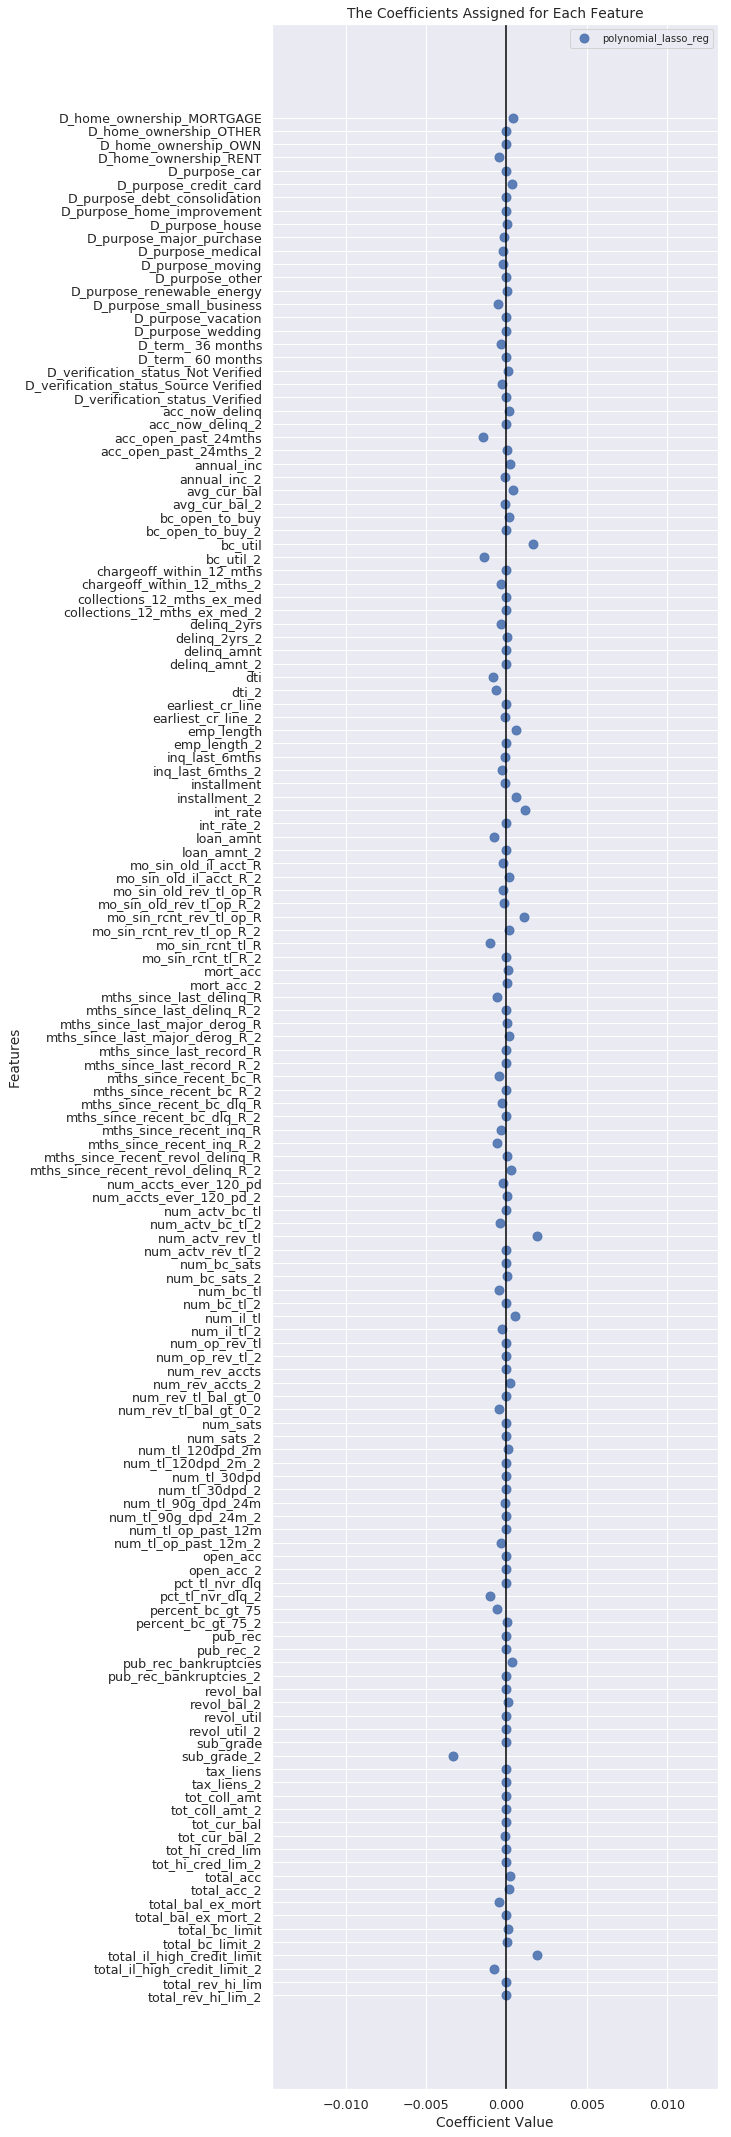

In [37]:
plot_coefficients(X_train_scaled_2, figsize=(8,38), polynomial_lasso_reg=lasso_reg2)

## 4. `OUT_Monthly_Rate_Of_Return`

### 4A. Baseline Regression

In [44]:
#DUMMY REGRESSOR OF 'OUT_Principle_Repaid_Percentage' 
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
print(dummy_reg)

DummyRegressor(constant=None, quantile=None, strategy='mean')


In [45]:
print('Train scores:')
model_scoring(dummy_reg, X_train_scaled, OUT_Monthly_Rate_Of_Return_train, modeltype='R')
print('Test scores:')
model_scoring(dummy_reg, X_test_scaled, OUT_Monthly_Rate_Of_Return_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -0.04668
	Cross-validation r2: -1.986e-05
Test scores:
	Cross-validation neg_mean_squared_error: -0.04709
	Cross-validation r2: -8.434e-05


### 4B. Linear Regression

In [46]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
print(linear_reg)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)


In [47]:
print('Train scores:')
model_scoring(linear_reg, X_train_scaled, OUT_Monthly_Rate_Of_Return_train, modeltype='R')
print('Test scores:')
model_scoring(linear_reg, X_test_scaled, OUT_Monthly_Rate_Of_Return_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -0.9982
	Cross-validation r2: -20.4
Test scores:
	Cross-validation neg_mean_squared_error: -0.9497
	Cross-validation r2: -19.21


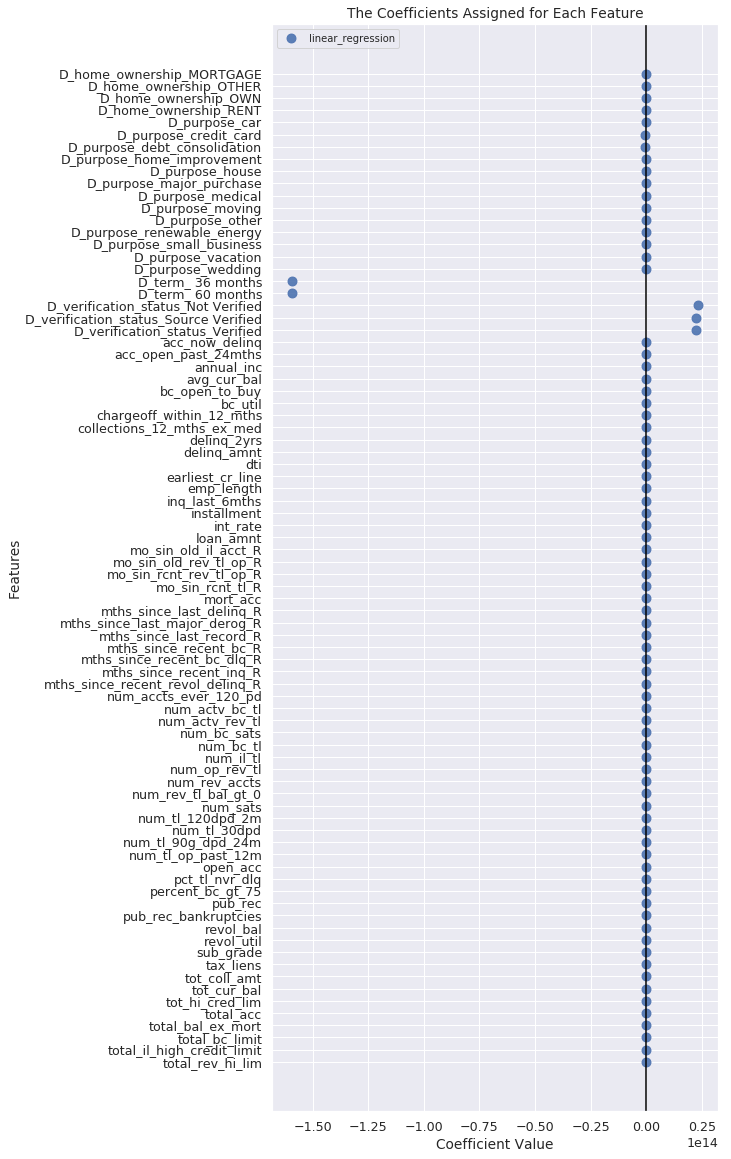

In [48]:
plot_coefficients(X_train_scaled, linear_regression=linear_reg)

### 4C. Ridge Regression

In [49]:
ridge_reg = RidgeCV(fit_intercept=False)
ridge_reg.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
ridge_reg

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=False,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [50]:
print("Train set scores:")
model_scoring(ridge_reg, X_train_scaled, OUT_Monthly_Rate_Of_Return_train, modeltype='R')
print("Test set scores:")
model_scoring(ridge_reg, X_test_scaled, OUT_Monthly_Rate_Of_Return_test, modeltype='R')

Train set scores:
	Cross-validation neg_mean_squared_error: -0.9208
	Cross-validation r2: -18.73
Test set scores:
	Cross-validation neg_mean_squared_error: -0.8948
	Cross-validation r2: -18.01


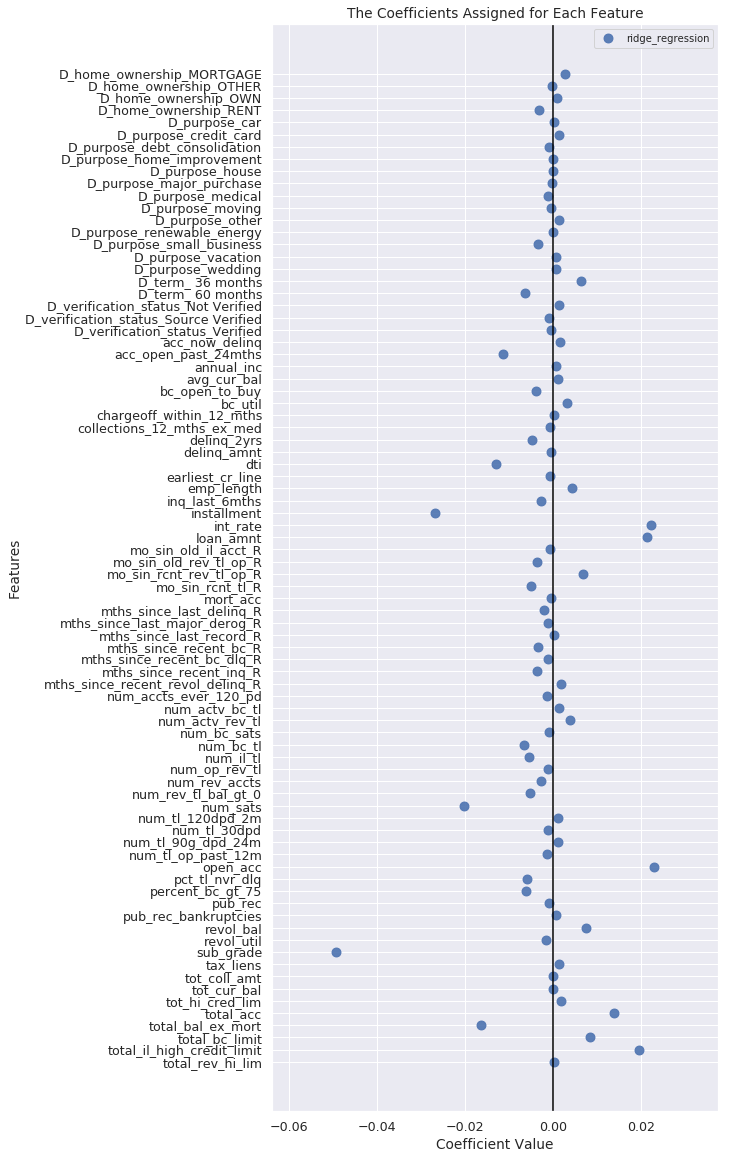

In [51]:
plot_coefficients(X_train_scaled, ridge_regression=ridge_reg)

### 4D. Lasso Regression

In [38]:
lasso_reg = LassoCV(fit_intercept=False)
lasso_reg.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
print(lasso_reg)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


In [39]:
print("Train set scores:")
model_scoring(lasso_reg, X_train_scaled, OUT_Monthly_Rate_Of_Return_train, modeltype='R')
print("Test set scores:")
model_scoring(lasso_reg, X_test_scaled, OUT_Monthly_Rate_Of_Return_test, modeltype='R')

Train set scores:
	Cross-validation neg_mean_squared_error: -0.8948
	Cross-validation r2: -18.17
Test set scores:
	Cross-validation neg_mean_squared_error: -0.8939
	Cross-validation r2: -17.99


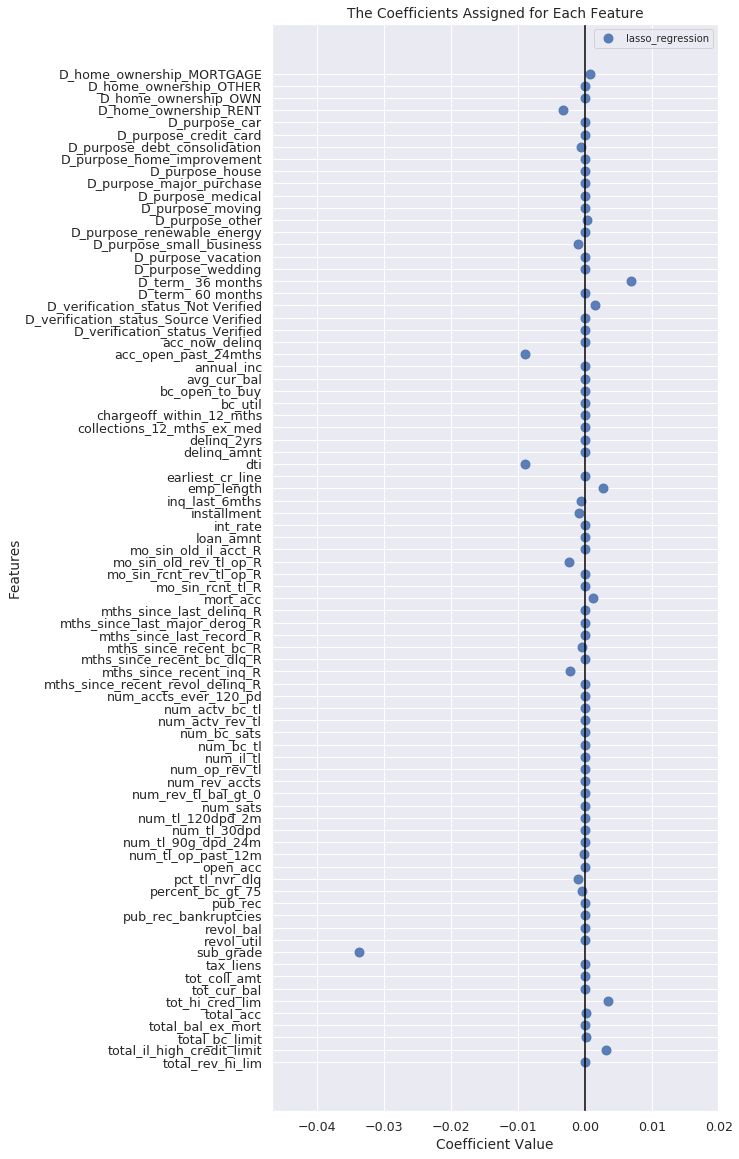

In [40]:
plot_coefficients(X_train_scaled, lasso_regression=lasso_reg)

### 4E. Polynomial Lasso Regression

In [41]:
lasso_reg2 = LassoCV(fit_intercept=False)
lasso_reg2.fit(X_train_scaled_2,OUT_Monthly_Rate_Of_Return_train)
print(lasso_reg2)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


In [42]:
print("Train scores:")
model_scoring(lasso_reg2, X_train_scaled_2, OUT_Monthly_Rate_Of_Return_train, modeltype='R')
print("Test scores:")
model_scoring(lasso_reg2, X_test_scaled_2, OUT_Monthly_Rate_Of_Return_test, modeltype='R')

Train scores:
	Cross-validation neg_mean_squared_error: -305.1
	Cross-validation r2: -6.566e+03
Test scores:
	Cross-validation neg_mean_squared_error: -0.676
	Cross-validation r2: -13.23


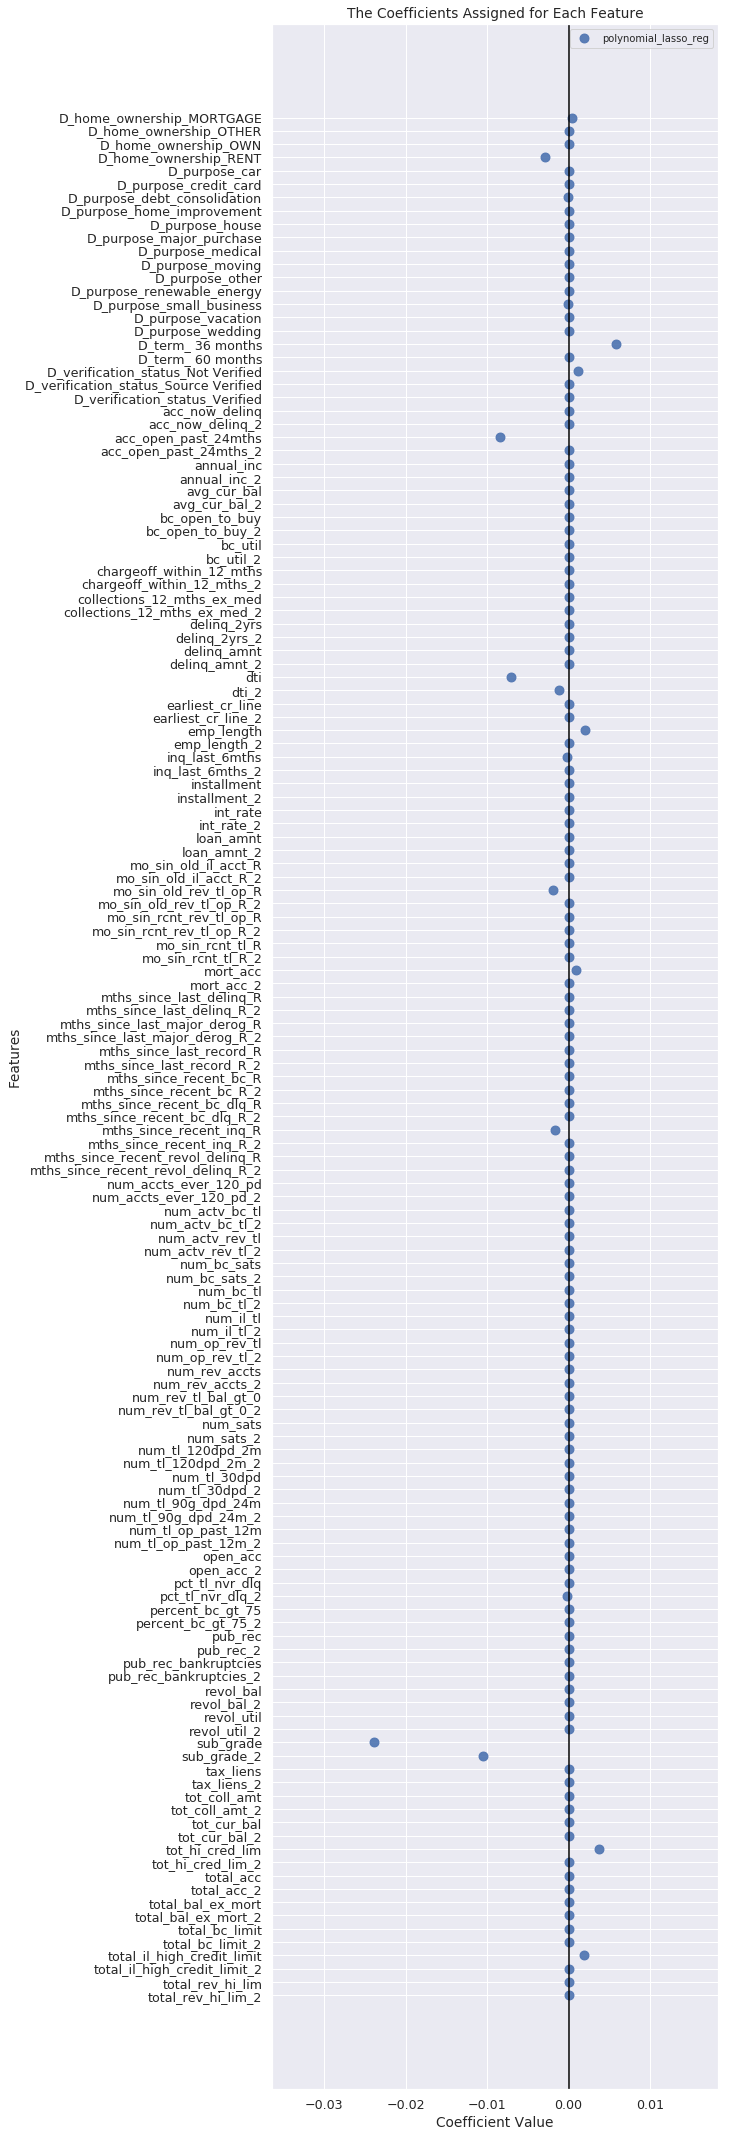

In [43]:
plot_coefficients(X_train_scaled_2, figsize=(8,38), polynomial_lasso_reg=lasso_reg2)